In [3]:
# import libraries
import requests
import time
from datetime import datetime, date, timedelta
import json
import sys
import random
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)  #allows display of all columns in dfs

# matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import table
%matplotlib inline

# tells the inline backend to not try to shrink wrap the figures which should fix the wrapped text
# https://github.com/matplotlib/matplotlib/issues/10869
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

# seaborn
import seaborn as sns
colors = ["#118AB2", "#EF476F", "#FFD166", "#06D6A0", "#EE754D", "#002E99"]
#plt.style.use('seaborn-whitegrid')

# plotly  https://plotly.com/python/figure-factory-table/
import plotly.figure_factory as ff

# sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine

In [4]:
# mysql login info
sys.path.insert(0, '../../Key')
from mysql_secret import dbuser, dbpass, dbhost, dbname
engine = create_engine(f'mysql://{dbuser}:{dbpass}@{dbhost}/{dbname}?charset=utf8')

In [5]:
# Establish Twitter connection
import tweepy

# get tweepy credentials
sys.path.insert(0, '../../Key')
from tweepy_keys import CONSUMER_KEY, CONSUMER_SECRET, ACCESS_KEY, ACCESS_SECRET

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_KEY, ACCESS_SECRET)

api = tweepy.API(auth)

In [6]:
def flatten_cols(df):
    df.columns = [
        '_'.join(tuple(map(str, t))).strip() 
        for t in df.columns.values
        ]
    return df

In [7]:
def remove_comp_suffix(df, company='company'):
    """Removes traling company name info that takes up space."""
    remove_text = [' /FL', '/DE', ', Inc.', ' Inc.', ', INC.', ' INC.',' PLC', ', Corp.', 'corp.', ' Corp.', ' CORP.', 
                   ' CORP',', Ltd', ' Ltd', ' plc',  ' PLC', ' SE']
    for t in remove_text:
        df[company] = df[company].str.rstrip(t)
    
    return df    

# Upcoming Week Schedule

In [8]:
# get range for today until one week from today
today = date.today()
week_from_today = today + timedelta(days=7)

#convert to string for query purposes from SQL
today = today.strftime("%Y-%m-%d")
week_from_today = week_from_today.strftime("%Y-%m-%d")

print(f"{today} to {week_from_today}")

2021-02-28 to 2021-03-07


In [9]:
connection = engine.connect()
tw_ipos_df = pd.read_sql(f"""
    SELECT *
    FROM stocks
    WHERE priced_date BETWEEN '{today}' and '{week_from_today}'
    """, connection)

In [ ]:
# convert to datetime
tw_ipos_df['priced_date'] =  pd.to_datetime(tw_ipos_df['priced_date'])

# add column for month day
tw_ipos_df["price_month_day"] = tw_ipos_df['priced_date'].dt.strftime('%b %d')

# add market cap
tw_ipos_df["market_cap"] = (tw_ipos_df['dollar_val_shares'].astype(float)/1000000).round(1).astype(str) + 'M'

# filter out SPACS
tw_ipos_df = tw_ipos_df.loc[(tw_ipos_df["exchange"] != 'NASDAQ Capital')]
tw_ipos_df = tw_ipos_df.loc[~(tw_ipos_df["company"].str.contains("Acquisition", regex=False))]  #any company that contains "Acquisition"

tw_ipos_df = tw_ipos_df.sort_values("priced_date")

# remove inc. and corp. and stuff like that from company name
tw_ipos_df = remove_comp_suffix(tw_ipos_df)
tw_ipos_df

In [ ]:
random_upcoming_ipo = [
    "check em out I guess",
    "I dunno who cares",
    "if you care",
    "are these good I dunno",
    "whats the point",
    "are any good?",
    "worth buying?",
    "are they overvalued",
    "any kewl ones?",
    "if you wanna dip a toe into em",
    "could be good or duds", 
    "this week",
    "... neat",
    "#stonks lmao right?",
    "from my robot",
    "coming at ya",
    "we'll see I guess", 
    "just cuz",
    "per the internet",
    "beep bop Im a robot",
    "schedule accordingly",
    "pass... or don't up to you",
    "at least thats the plan", 
    "have a good week",
    "kewl kewl kewl",
    "might buy all or none or some",
    "thanks for stopping by"
    ]

In [ ]:
# get tweet text 
tweet_text = f"Upcoming IPOs {random.choice(random_upcoming_ipo)}\n"

for row in tw_ipos_df.itertuples():
    
    # remove .00 from proposed share prices to reduce unecesary characters
    psp = row.proposed_share_price.replace(".00", "")
    
    # if going to exceed the length of twitter characters allowed then break out of loop
    if len(tweet_text) > 245:
        break
    else:
        tweet_text += "\n"
        row_text = f"{row.price_month_day}: ${row.symbol} at ${psp}" 
        tweet_text += row_text
print(tweet_text)
print(f"******\nCharacter Count: {len(tweet_text)}")


In [ ]:
# table for tweet image
tw_ipos_img_df = tw_ipos_df[['price_month_day', 'symbol', 'company', 'proposed_share_price', 'market_cap']]
tw_ipos_img_df['proposed_share_price'] = "$" + tw_ipos_img_df['proposed_share_price']
tw_ipos_img_df = tw_ipos_img_df.rename(columns={'price_month_day': 'Date',
                                                'symbol': 'Symbol',
                                                'company': 'Company',
                                                'proposed_share_price': 'Proposed Price',
                                                'market_cap': 'Market Cap'
                                               })
tw_ipos_img_df

In [ ]:
# get tweet image
# info on how to save static image:  https://plotly.com/python/static-image-export/
colorscale = [[0, '#118AB2'],[.5, '#FFFFFF'],[1, '#F2F2F2']]
fig =  ff.create_table(tw_ipos_img_df, colorscale=colorscale, height_constant=20)

fig.write_image("weekly_ipos.png", scale = 1)
fig.show()

In [ ]:
# the name of the media file 
filename = "weekly_ipos.png"

# upload the file 
media = api.media_upload(filename) 

In [ ]:
# Send out the tweet
api.update_with_media(filename="weekly_ipos.png", media_id=media.media_id, status=tweet_text)

# Stock Goes Live Today

In [10]:
random_goes_live_today = [
    "see what they're about below",
    "below are the #things they #do",
    "here's some more info",
    "#read about them below",
    "what are they about? just look below...",
    "who the heck are they? this is the heck that they are...",
    "wanna learn more?",
    "are you gonna buy them or not buy them?", 
    "might buy them or might not...",
    "this is financial advise (just kidding)",
    "some things you should know...",
    "beep bop I'm a robot this is what I know about them",
    "here's what they do",
    "check em out",
    "who cares (if you do here's more on them)",
    "write up about who they are below",
    "this is what their business does", 
    "this is what they do",
    "ok more is below if you care if you don't thats fine too", 
    "thanks for stopping by here's a lil more on them below",
    "learn more below"
    ]

In [11]:
random_end_of_desc = [
    "yada yada yada you get it",
    "ok look if you're still reading go to their website",
    "I think we get the point",
    "you're getting bored that's enough for now",
    "blah blahhhh blah blahhhh blah we get it #amiright",
    "well that's most of it",
    "ok goofballs that's enough for now",
    "a solid mix of interesting and not interesting!", 
    "okey doke I got it",
    "you get the picture",
    "and then there's some more stuff but I digress",
    "makes sense to me by now",
    "ok... got it",
    "neat I guess",
    "sounds unique or not unique depends who you talk to",
    "omg WE GET IT",
    "so that's what they do", 
    "enough story time on them for now",
    "ugh who cares", 
    "Robot needs a rest that's enough info for now",
]

In [29]:
# get todays date
today = datetime.today().strftime("%Y-%m-%d")

# # date if testing
today = '2021-02-11'

In [30]:
# get stocks that go live today
engine = create_engine(f'mysql://{dbuser}:{dbpass}@{dbhost}/{dbname}?charset=utf8')
connection = engine.connect()
df = pd.read_sql(f"""
    SELECT s.*, 
        ci.city, 
        ci.state,
        ci.country,
        ci.website, 
        ci.industry,
        ci.sector, 
        ci.business_summary
    FROM stocks s
    LEFT JOIN company_info ci
        ON s.symbol = ci.symbol
    WHERE priced_date = '{today}'
        AND exchange <> 'NASDAQ Capital'""", connection)
connection.close()
df['region'] = np.where(df['country']=='United States', df['city'] + ", " + df['state'], 
                        df['city'] + ", " + df['country'])
df

,symbol,company,exchange,proposed_share_price,shares_offered,priced_date,dollar_val_shares,deal_status,proposed_cap_classifiction,city,state,country,website,industry,sector,business_summary,region
0,APR,"Apria, Inc.",NASDAQ Global Select,20.00,7500000,2021-02-11,1.500000e+08,priced,Micro-cap,Lake Forest,CA,United States,,Medical Instruments & Supplies,Healthcare,Apria Healthcare Group Inc. provides home heal...,"Lake Forest, CA"
1,BMBL,Bumble Inc.,NASDAQ Global Select,43.00,50000000,2021-02-11,2.150000e+09,priced,Mid-cap,Austin,TX,United States,http://bumble.com,Software—Application,Technology,Bumble Inc. operates online dating and social ...,"Austin, TX"
2,BVS,Bioventus Inc.,NASDAQ Global,13.00,8000000,2021-02-11,1.040000e+08,priced,Micro-cap,Durham,NC,United States,http://www.bioventusglobal.com,Diagnostics & Research,Healthcare,Bioventus Inc. focuses on operating as a holdi...,"Durham, NC"
3,IACBU,ION Acquisition Corp 2 Ltd.,NYSE,10.00,22000000,2021-02-11,2.200000e+08,priced,Micro-cap,None,None,None,None,None,None,None,NaN
4,LDI,"loanDepot, Inc.",NYSE,14.00,3850000,2021-02-11,5.390000e+07,priced,Micro-cap,Foothill Ranch,CA,United States,http://www.loandepot.com,Mortgage Finance,Financial Services,"loanDepot, Inc. engages in the origination and...","Foothill Ranch, CA"
5,SGFY,"Signify Health, Inc.",NYSE,24.00,23500000,2021-02-11,5.640000e+08,priced,Small-cap,Dallas,TX,United States,http://www.signifyhealth.com,Health Information Services,Healthcare,"Signify Health, Inc. operates a healthcare pla...","Dallas, TX"


In [31]:
# filter out SPACS
df = df.loc[(df["exchange"] != 'NASDAQ Capital')]
df = df.loc[~(df["company"].str.contains("Acquisition", regex=False))]  #any company that contains "Acquisition"

# keep only ones that have region and industry
df = df.dropna(subset=['region', 'industry'])

# add market cap
df["market_cap"] = (df['dollar_val_shares'].astype(float)/1000000).round(1).astype(str) + 'M'
df               

,symbol,company,exchange,proposed_share_price,shares_offered,priced_date,dollar_val_shares,deal_status,proposed_cap_classifiction,city,state,country,website,industry,sector,business_summary,region,market_cap
0,APR,"Apria, Inc.",NASDAQ Global Select,20.00,7500000,2021-02-11,1.500000e+08,priced,Micro-cap,Lake Forest,CA,United States,,Medical Instruments & Supplies,Healthcare,Apria Healthcare Group Inc. provides home heal...,"Lake Forest, CA",150.0M
1,BMBL,Bumble Inc.,NASDAQ Global Select,43.00,50000000,2021-02-11,2.150000e+09,priced,Mid-cap,Austin,TX,United States,http://bumble.com,Software—Application,Technology,Bumble Inc. operates online dating and social ...,"Austin, TX",2150.0M
2,BVS,Bioventus Inc.,NASDAQ Global,13.00,8000000,2021-02-11,1.040000e+08,priced,Micro-cap,Durham,NC,United States,http://www.bioventusglobal.com,Diagnostics & Research,Healthcare,Bioventus Inc. focuses on operating as a holdi...,"Durham, NC",104.0M
4,LDI,"loanDepot, Inc.",NYSE,14.00,3850000,2021-02-11,5.390000e+07,priced,Micro-cap,Foothill Ranch,CA,United States,http://www.loandepot.com,Mortgage Finance,Financial Services,"loanDepot, Inc. engages in the origination and...","Foothill Ranch, CA",53.9M
5,SGFY,"Signify Health, Inc.",NYSE,24.00,23500000,2021-02-11,5.640000e+08,priced,Small-cap,Dallas,TX,United States,http://www.signifyhealth.com,Health Information Services,Healthcare,"Signify Health, Inc. operates a healthcare pla...","Dallas, TX",564.0M


In [32]:
row_count = len(df.index)
row_count

5

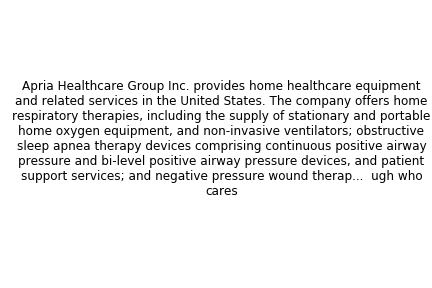

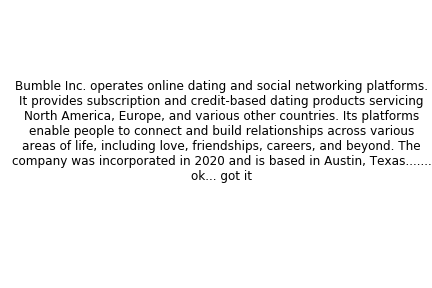

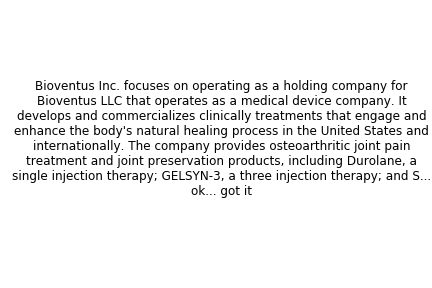

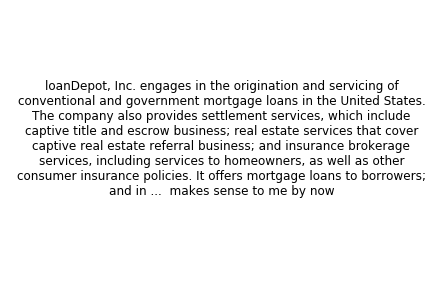

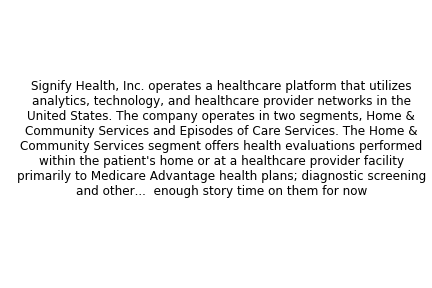

In [37]:
if row_count > 0:
    for row in df.itertuples():
        
        symbol = row.symbol
        company = row.company
        industry = row.industry.lower()
        region = row.region
        business_summary = "\n\n\n" + row.business_summary
        business_summary.replace('\\n', '\n')
        business_summary = business_summary[:455] + "... "
                
        # get tweet text
        tweet_text = f"{company} ${symbol} should trade today, a {industry} company out of {region} ... {random.choice(random_goes_live_today)} \n\nPrice Range: ${row.proposed_share_price} \nMarket Cap: ${row.market_cap}"
        tweet_text.replace('\\n', '\n')
        
        # text for image of company description
        description = business_summary + " " + random.choice(random_end_of_desc)
        
        # company description image
        fig = plt.figure(figsize=(6,4))
        ax = fig.add_subplot(111)
        ax.axis([0, 10, 0, 10])
        ax.text(5, 10, description, fontsize=12, style='normal', ha='center',
                 va='top', wrap=True, bbox={'facecolor': 'none', 'edgecolor': 'none', 'alpha': 0.2, 'pad': 5})
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.savefig('comp_desc.png')
        plt.show

        # the name of the media file 
#         filename = "comp_desc.png"

        # upload the file 
#         media = api.media_upload(filename) 
        
        # Send out the tweet
#         api.update_with_media(filename="comp_desc.png", media_id=media.media_id, status=tweet_text)
        
        time.sleep(1)

# Performance Analysis

In [ ]:
connection = engine.connect()
ipo_df = pd.read_sql("SELECT * FROM ipo_tracker.vw_stocks_performance", connection)
connection.close()
ipo_df.head()

## Sector and Industry

In [ ]:
# remove stocks with None or blank as sector / industry
si_data_df = ipo_df[(ipo_df["industry"].notnull()) & (ipo_df["industry"] != "")
            & (ipo_df["sector"].notnull()) & (ipo_df["sector"] != "")]
si_data_df.head(2)

### Sector by Year

In [ ]:
sector_by_year_df = si_data_df.pivot_table(index='sector', columns='first_trade_year', 
                                    aggfunc={"symbol": 'count'})
sector_by_year_df = sector_by_year_df.fillna(0).sort_values(by=sector_by_year_df.columns[-1], ascending=True)

# pass to function to flatten columns
sector_by_year_df = flatten_cols(sector_by_year_df)
sector_by_year_df


In [ ]:
ax = sector_by_year_df.plot(kind="barh", figsize=(8,7), color=colors, zorder=3, width=0.75)
ax.grid(which="major", axis='both', color='#e6e6e6', zorder=0)
ax.legend([2018, 2019, 2020])
ax.set_ylabel(f'Sector', fontsize=12)
ax.set_xlabel(f'IPOs Count', fontsize=12)
ax.set_title("IPO Count by Sector", fontsize=20)
plt.show()

## Top Performing n Period

Values for analysis

In [ ]:
# example stock to view
stock_symbol = 'ABCM' 

Data preparation

In [ ]:
# add price change column
sa_df = ipo_df.copy()
sa_df["first_close_to_rec_close"] = sa_df["most_recent_close"] / sa_df["first_day_close"] - 1
sa_df.head(5)

In [ ]:
# get sector for stock of interest
stock_sector = sa_df.loc[sa_df["symbol"] == stock_symbol]["sector"].iloc[0]
print(f"{stock_symbol} is in the {stock_sector} sector")

# get industry for stock of interest
stock_industry = sa_df.loc[sa_df["symbol"] == stock_symbol]["industry"].iloc[0]
print(f"{stock_symbol} is in the {stock_industry} industry")

# get market cap classification for stock of interest
stock_market_cap = sa_df.loc[sa_df["symbol"] == stock_symbol]["market_cap_classification"].iloc[0]
print(f"{stock_symbol} is a {stock_market_cap} market cap")

In [ ]:
# create new columns for vizualization
# sector
conditions = [(sa_df["symbol"] == stock_symbol), (sa_df["sector"] == stock_sector)]
choices = [stock_symbol, stock_sector]
sa_df["Stock Sector"] = np.select(conditions, choices, "Other")

# industry
conditions = [(sa_df["symbol"] == stock_symbol), (sa_df["industry"] == stock_industry)]
choices = [stock_symbol, stock_industry]
sa_df["Stock Industry"] = np.select(conditions, choices, "Other")

# market cap
conditions = [(sa_df["symbol"] == stock_symbol), (sa_df["industry"] == stock_market_cap)]
choices = [stock_symbol, stock_market_cap]
sa_df["Stock Market Cap"] = np.select(conditions, choices, "Other")

sa_df.head(2)

In [ ]:
# data for plotting sector in similar market cap
sa_mc_df = sa_df[sa_df["market_cap_classification"] == stock_market_cap]
sa_mc_df

In [ ]:
# Plot
colors = ["#118AB2", "#EF476F", "#d9d9d9"]
sns.lmplot('days_trading', 'first_close_to_rec_close', data=sa_mc_df, hue='Stock Sector', 
           palette=colors[0:3], scatter_kws={"s": 100}, fit_reg=True, height=6, aspect=1.6)
plt.title("Performance Over Time", fontsize=20)
plt.suptitle(f"{stock_market_cap} IPOs", fontsize=15)
plt.ylabel("YOY Change")
plt.xlabel("Days Trading")
plt.grid(which="major", axis='both', color='#e6e6e6', zorder=0)


In [ ]:
# remove stocks with None or blank as sector / industry
ax1 = sa_df.plot(kind="scatter", x="market_cap", y="first_close_to_rec_close", c=colors[0], figsize=(8,7), zorder=3)
ax.margins(0.05)

In [ ]:
sns.relplot(
    data=sa_df,
    x="days_trading", y="first_close_to_rec_close", col="market_cap_classification", col_wrap=3,
    hue="Stock Sector", palette=colors[0:3]
)

In [ ]:
## More on creating text in matplotlib images
# import matplotlib
# import matplotlib.pyplot as plt

# fig = plt.figure()
# fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')

# ax = fig.add_subplot(111)
# fig.subplots_adjust(top=0.85)
# ax.set_title('axes title')

# ax.set_xlabel('xlabel')
# ax.set_ylabel('ylabel')

# ax.text(3, 8, 'boxed italics text in data coords', style='italic',
#         bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

# ax.text(2, 6, r'an equation: $E=mc^2$', fontsize=15)

# ax.text(3, 2, 'unicode: Institut für Festkörperphysik')

# ax.text(0.95, 0.01, 'colored text in axes coords',
#         verticalalignment='bottom', horizontalalignment='right',
#         transform=ax.transAxes,
#         color='green', fontsize=15)


# ax.plot([2], [1], 'o')
# ax.annotate('annotate', xy=(2, 1), xytext=(3, 4),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# ax.axis([0, 10, 0, 10])

# plt.show()

In [ ]:
# # table image with mpl option
# https://stackoverflow.com/questions/19726663/how-to-save-the-pandas-dataframe-series-data-as-a-figure

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# df = pd.DataFrame()
# df['date'] = ['2016-04-01', '2016-04-02', '2016-04-03']
# df['calories'] = [2200, 2100, 1500]
# df['sleep hours'] = [8, 7.5, 8.2]
# df['gym'] = [True, False, False]

# def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=12,
#                      header_color='#118AB2', row_colors=['#f1f1f2', 'w'], edge_color='w',
#                      bbox=[0, 0, 1, 1], header_columns=0,
#                      ax=None, **kwargs):
#     if ax is None:
#         size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
#         fig, ax = plt.subplots(figsize=size)
#         ax.axis('off')
#     mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
#     mpl_table.auto_set_font_size(False)
#     mpl_table.set_fontsize(font_size)

#     for k, cell in mpl_table._cells.items():
#         cell.set_edgecolor(edge_color)
#         if k[0] == 0 or k[1] < header_columns:
#             cell.set_text_props(weight='bold', color='w')
#             cell.set_facecolor(header_color)
#         else:
#             cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
#     return ax.get_figure(), ax

# fig,ax = render_mpl_table(tw_ipos_img_df, header_columns=0, col_width=2.5)
# fig.savefig("table_mpl.png")